In [ ]:
# default_exp camera_project

# camera_project

> A toolset for rosbag created by arg lab.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#|export
#nbdev_comment from __future__ import print_function

import os
import argparse
import cv2
import rosbag
import yaml
import time
import apriltag
import pytransform3d.rotations as pr
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
from sensor_msgs.msg import Image
plt.rcParams['figure.figsize'] = (40, 40)        # large images

def vis_apriltag(image, results):
    '''
        draw the line segments around the tag, and add the tag id.
    '''
    # loop over the AprilTag detection results
    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))
        #get the corner point for big apriltag
        tag_id = str(r.tag_id)
        if tag_id == '201':
            big_ptA = ptA
        if tag_id == '2':
            big_ptB = ptB
            # draw the center (x, y)-coordinates of the AprilTag
            cv2.circle(image, ptD, 5, (255, 0, 255), -1)
        if tag_id == '203':
            big_ptC_1 = ptC
        if tag_id == '204':
            big_ptC_2 = ptC
        if tag_id == '1':
            big_ptD = ptD
            
    ptA_List = list(big_ptA)
    ptB_List = list(big_ptB)
    ptC_List = list(big_ptC_1)
    ptC_List[1] = big_ptC_2[1]
    big_ptC = tuple(ptC_List)
    ptD_List = list(big_ptD)
    # get up box
    H = 100
    ptA_List_up = ptA_List
    ptA_List_up[1] -= H
    ptB_List_up = ptB_List
    ptB_List_up[1] -= H
    ptC_List_up = ptC_List
    ptC_List_up[1] -= H
    ptD_List_up = ptD_List
    ptD_List_up[1] -= H
    #
    big_ptA_up = tuple(ptA_List_up)
    big_ptB_up = tuple(ptB_List_up)
    big_ptC_up = tuple(ptC_List_up)
    big_ptD_up = tuple(ptD_List_up)
    # draw the bounding box of the AprilTag detection
    color = (0, 0, 255)
    cv2.line(image, big_ptA, big_ptB, color, 2)
    cv2.line(image, big_ptB, big_ptC, color, 2)
    cv2.line(image, big_ptC, big_ptD, color, 2)
    cv2.line(image, big_ptD, big_ptA, color, 2)
    # draw line from lower box to upper box
    color = (0, 255, 255)
    cv2.line(image, big_ptA, big_ptA_up, color, 2)
    cv2.line(image, big_ptB, big_ptB_up, color, 2)
    cv2.line(image, big_ptC, big_ptC_up, color, 2)
    cv2.line(image, big_ptD, big_ptD_up, color, 2)
    # draw upper box
    color = (0, 0, 255)
    cv2.line(image, big_ptA_up, big_ptB_up, color, 2)
    cv2.line(image, big_ptB_up, big_ptC_up, color, 2)
    cv2.line(image, big_ptC_up, big_ptD_up, color, 2)
    cv2.line(image, big_ptD_up, big_ptA_up, color, 2)
    return image

def detect_apriltag(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    options = apriltag.DetectorOptions(families="tag36h11")
    detector = apriltag.Detector(options)
    results = detector.detect(gray)
    dst = vis_apriltag(dst, results)
    detection_results, dimg = detector.detect(gray, return_image=True)
    for r in results:
        print("id: {}, center: {}".format(r.tag_id, r.center))
    print("[INFO] {} total AprilTags detected".format(len(results)))
    plt.subplot(132),plt.imshow(dst, cmap = 'brg')
    plt.title('AprilTags'), plt.xticks([]), plt.yticks([])
    return

## Test

In [ ]:
cd data

[Errno 2] No such file or directory: 'data'
/home/arg/arg_ros_tools/data


In [ ]:
ls

dreamvu.bag  extract/  tag.png  zed.bag


id: 1, center: [593.06479121 564.86750745]
id: 2, center: [535.48083824 534.91575232]
id: 201, center: [527.90555698 576.73744185]
id: 202, center: [552.12100946 558.04305022]
id: 203, center: [599.47762394 539.83293869]
id: 204, center: [571.55414734 525.64828262]
[INFO] 6 total AprilTags detected


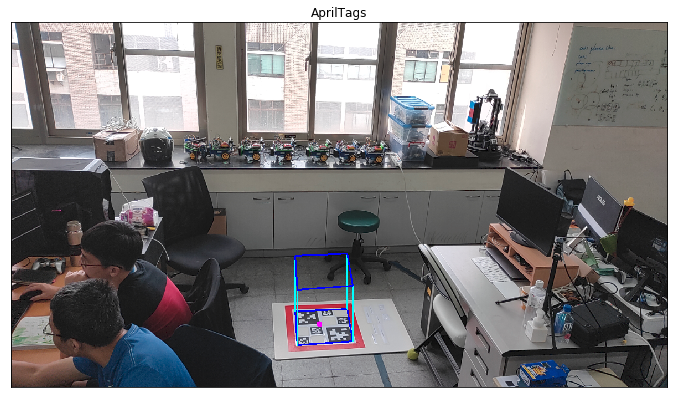

In [ ]:
detect_apriltag('tag.png')